In [196]:
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from modules import UNet
import torch.nn as nn
import torch.nn.functional as F


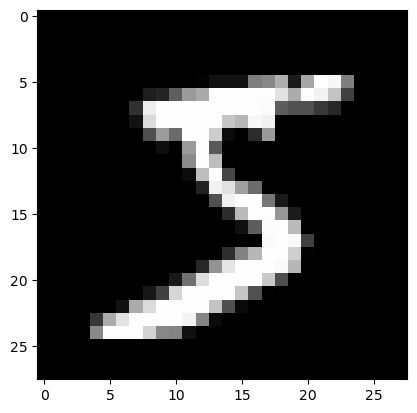

In [38]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=1, shuffle=False)
image, label = next(iter(train_loader))

# Plot the image
plt.imshow(image.squeeze(), cmap='gray')
#plt.title(f'Label: {training_data.classes[label]}')
plt.show()

In [133]:
dataset = torchvision.datasets.CIFAR10(root = 'data' , train=True) 

# Create a dataloader to iterate over the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4)

# Get a batch of images and labels
images, labels = next(iter(dataloader))

# Make a grid from the batch
grid = torchvision.utils.make_grid(images)

# Convert the grid to numpy array
grid_np = grid.numpy()

# Transpose the grid to match the format expected by matplotlib (H, W, C)
grid_np = np.transpose(grid_np, (1, 2, 0))

# Plot the grid
plt.imshow(grid_np)
plt.show()

RuntimeError: Dataset not found or corrupted. You can use download=True to download it

In [154]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
])

# Load the dataset
dataset = datasets.ImageFolder(root = 'train', transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Iterate over the dataset
#for images, labels in dataloader:
    # Process the images and labels
    #print(images.shape, labels)

In [60]:
def unnormalize(img, mean, std):
    """
    Unnormalizes a tensor that was normalized using the given mean and std.
    
    Args:
    - img (torch.Tensor): The normalized image tensor.
    - mean (tuple or list): The mean used for normalization (per channel).
    - std (tuple or list): The standard deviation used for normalization (per channel).
    
    Returns:
    - torch.Tensor: The unnormalized image tensor.
    """
    img = img.clone()  # Clone the tensor to avoid modifying the original image
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # img = img * std + mean
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


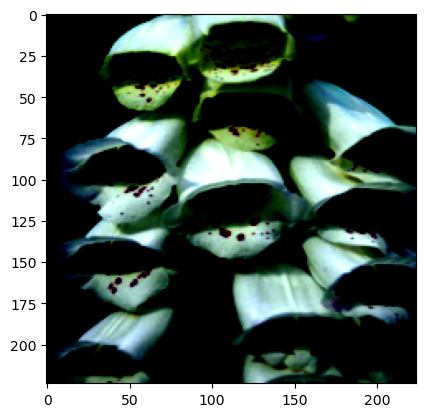

In [140]:
image,_ = next(iter(dataloader))
c=[0.485, 0.456, 0.406]
s=[0.229, 0.224, 0.225]
img = image[5]
image_unm = unnormalize(img,c,s)

plt.imshow(img.permute([1,2,0]))


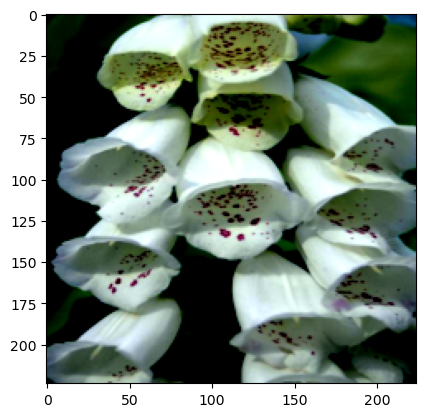

In [141]:
x = (img.clamp(-1,1)+1)/2
plt.imshow(x.permute([1,2,0]))

usage: ipykernel_launcher.py [-h]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/saptarshiroy/Library/Jupyter/runtime/kernel-v2-97848RsbPdazbHh1V.json


SystemExit: 2

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [246]:
import rectified_flow as rf
import os
from torch.utils.tensorboard import SummaryWriter
import logging
from tqdm import tqdm

In [247]:
args = {}
args['run_name'] = "Rectified flow"
args['epochs'] = 100
args['batch_size'] = 32
args['img_size'] = 224
args['dataloader']= dataloader
args['device'] = 'cpu'
args['lr'] = 3e-4

args


{'run_name': 'Rectified flow',
 'epochs': 100,
 'batch_size': 32,
 'img_size': 224,
 'dataloader': <torch.utils.data.dataloader.DataLoader at 0x15cf2a600>,
 'device': 'cpu',
 'lr': 0.0003}

In [248]:
loc_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

time_steps = 1000; img_size = 256; 
device = loc_device.type
dataloader = args['dataloader']
model = UNet().to(device) #UNet.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = args['lr'])
mse = nn.MSELoss()
rect_flow = rf.rectified_flow(img_size = args['img_size'], device = device)
logger = SummaryWriter(os.path.join("runs", args['run_name']))
l = len(dataloader)

In [249]:
for epoch in range(args['epochs']):
    logging.info(f"Starting epoch {epoch}:")
    pbar = tqdm(dataloader)
    for i, (images,_) in enumerate(pbar):
        images = images.to(device)
        t = rect_flow.sample_timesteps(images.shape[0]).to(device)
        x_t, z = rect_flow.noise_images(images, t)
        predict_velocity = model(x_t, t)
        loss = mse(images - z, predict_velocity)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(MSE = loss.item())
        logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)
    
sampled_images = rect_flow.sample(model, n = images.shape[0])
#return(sampled_images)


  0%|          | 0/205 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (32) must match the size of tensor b (224) at non-singleton dimension 3

In [232]:
images.shape
z = torch.randn_like(images)
t * z+ t*x


RuntimeError: The size of tensor a (32) must match the size of tensor b (224) at non-singleton dimension 3

In [256]:
rf.rectified_flow.noise_images(images, t)

TypeError: rectified_flow.noise_images() missing 1 required positional argument: 't'

In [254]:
t

tensor([0.9691, 0.8732, 0.9378, 0.2914, 0.8184, 0.0519, 0.7570, 0.7081, 0.8486,
        0.1572, 0.9903, 0.0665, 0.3142, 0.3964, 0.1365, 0.3066, 0.0504, 0.0379,
        0.0969, 0.7903, 0.3843, 0.4358, 0.3823, 0.2958, 0.9691, 0.4863, 0.1686,
        0.7004, 0.5681, 0.5682, 0.9665, 0.8213])